<a href="https://colab.research.google.com/github/ArthAgrawal/Deepfake-Audio-Detection/blob/main/Deepfake_Audio_Project_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Audiomentations is the library used for audio augmentations**

In [ ]:
!pip install audiomentations

**TTS(Text To Speech): Speech is generated directly from text using a GAN or some form of AI (Text -> Speech) <br>
VC(Voice Conversion): Takes a real speaker's voice and converts it to sound like another (Voice A -> Voice B)<br> Each class has ~3800 audio files**

In [3]:
import os
import matplotlib.pyplot as plt

directories = {
    'Bonafide': '/content/drive/MyDrive/ASV_Dataset/Bonafide',
    'Spoof-A01': '/content/drive/MyDrive/ASV_Dataset/Spoof/A01',
    'Spoof-A02': '/content/drive/MyDrive/ASV_Dataset/Spoof/A02',
    'Spoof-A03': '/content/drive/MyDrive/ASV_Dataset/Spoof/A03',
    'Spoof-A04': '/content/drive/MyDrive/ASV_Dataset/Spoof/A04',
    'Spoof-A05': '/content/drive/MyDrive/ASV_Dataset/Spoof/A05',
    'Spoof-A06': '/content/drive/MyDrive/ASV_Dataset/Spoof/A06',
}

**PCA** <br>(Reducing data dimensions while keeping the most important information) <br> Audios have 13 dimensions (13 MFCC (Mel-Frequency Cepstral Coefficients) values) <br> PCA helps convert them from 13D to 2D <br>
PC1: The direction in feature space where the data varies the most (Basically the most important feature) <br>
PC2: The direction with the second most variation (Second most important feature)

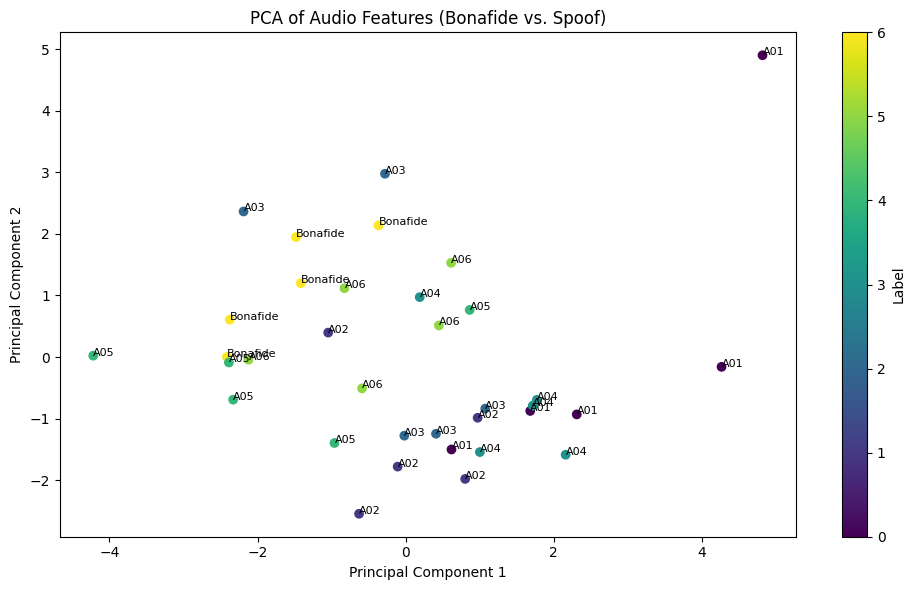

In [8]:
import os
import random
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

DATASET_ROOT = "/content/drive/MyDrive/ASV_Dataset"

audio_dirs = {
    "Bonafide": f"{DATASET_ROOT}/Bonafide",
    "A01": f"{DATASET_ROOT}/Spoof/A01",
    "A02": f"{DATASET_ROOT}/Spoof/A02",
    "A03": f"{DATASET_ROOT}/Spoof/A03",
    "A04": f"{DATASET_ROOT}/Spoof/A04",
    "A05": f"{DATASET_ROOT}/Spoof/A05",
    "A06": f"{DATASET_ROOT}/Spoof/A06",
}

SAMPLES_PER_CLASS = 5
features = []
labels = []

# Randomly sampling audio files
for label, folder in audio_dirs.items():
    files = [f for f in os.listdir(folder) if f.endswith(".flac")]
    selected_files = random.sample(files, min(SAMPLES_PER_CLASS, len(files)))

    for file in selected_files:
        path = os.path.join(folder, file)
        mfcc = extract_features(path)
        features.append(mfcc)
        labels.append(label)

# Converting features and labels to numpy arrays
features = np.array(features)

# Encoding the labels as numeric values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    features_pca[:, 0],
    features_pca[:, 1],
    c=labels_encoded,
    cmap='viridis',
    label='Data points'
)

for i, txt in enumerate(labels):
    plt.annotate(txt, (features_pca[i, 0], features_pca[i, 1]), fontsize=8)

plt.title('PCA of Audio Features (Bonafide vs. Spoof)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Label')
plt.tight_layout()
plt.show()

**1D Waveform of each class**

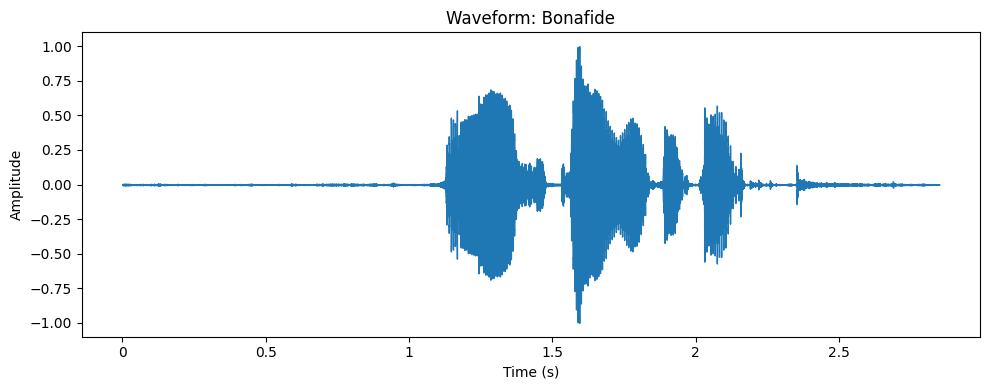

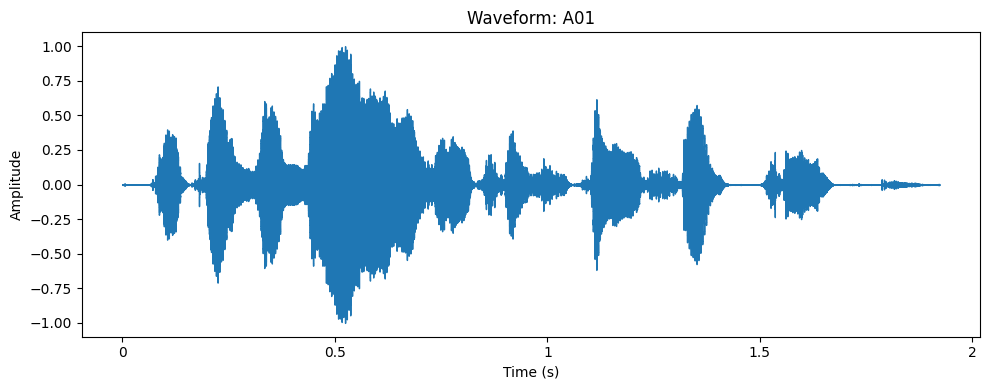

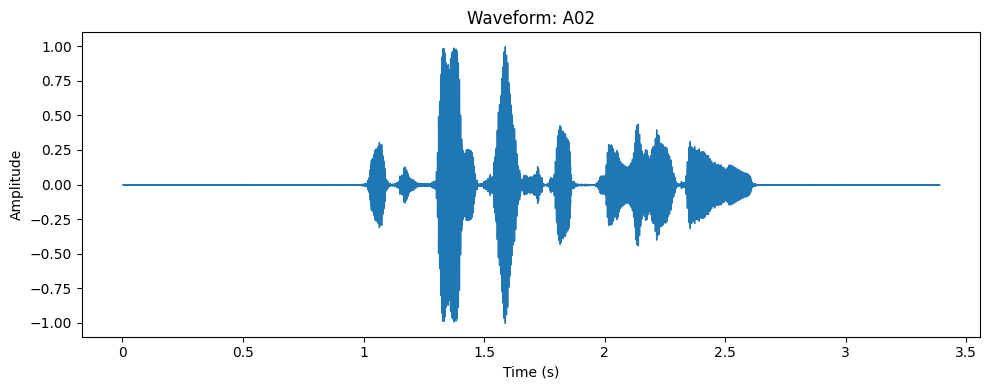

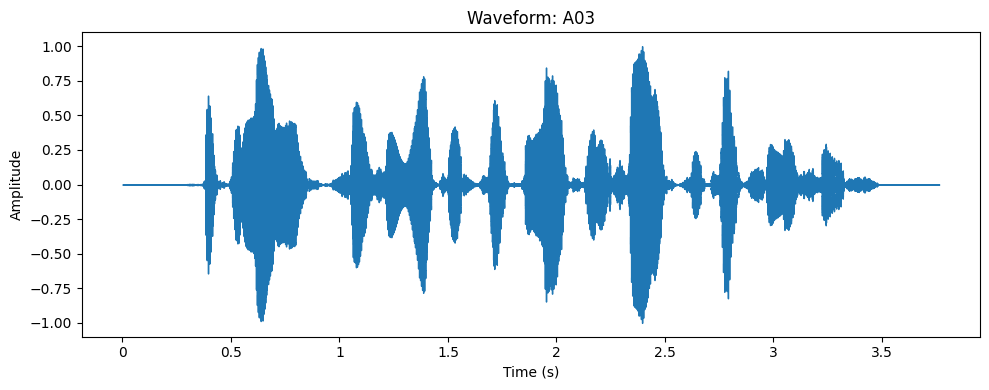

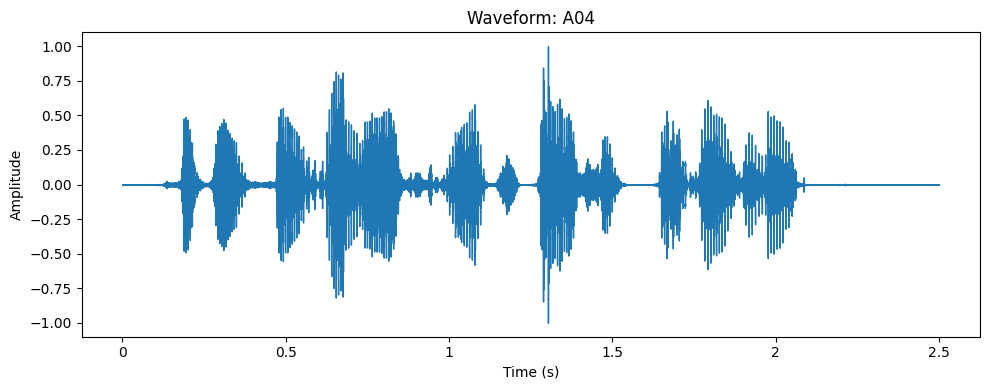

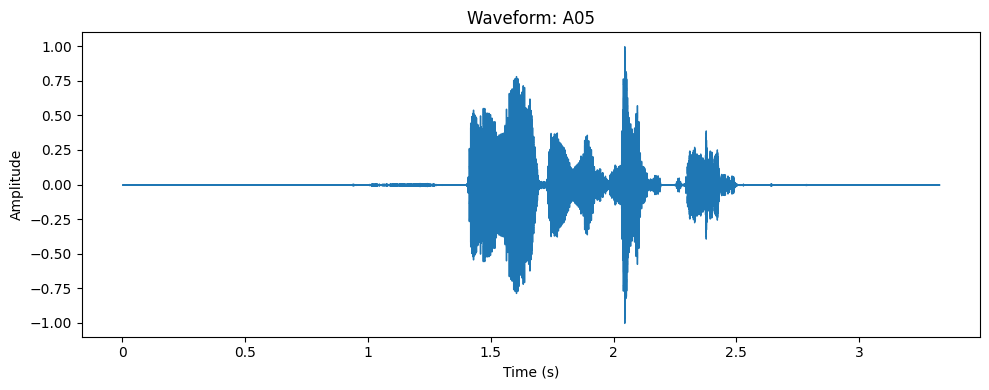

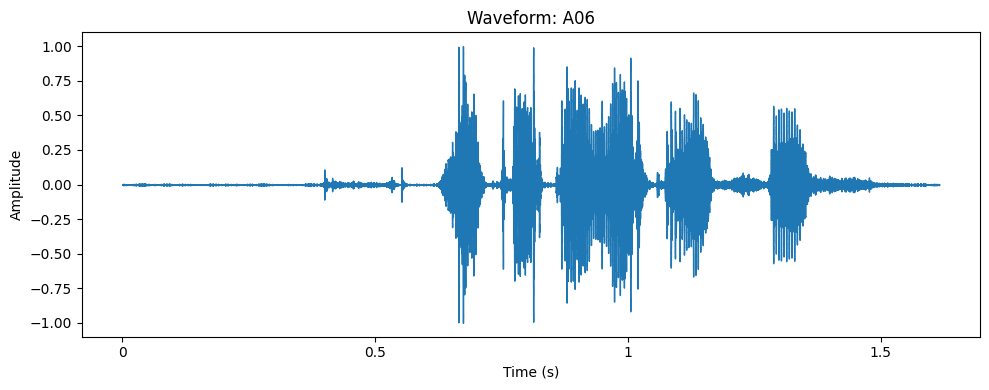

In [10]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_waveform(audio_path, title="Waveform"):
    y, sr = librosa.load(audio_path, sr=None)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

audio_paths = {
    "Bonafide": "/content/drive/MyDrive/ASV_Dataset/Bonafide/LA_T_1000406.flac",
    "A01": "/content/drive/MyDrive/ASV_Dataset/Spoof/A01/LA_T_1000648.flac",
    "A02": "/content/drive/MyDrive/ASV_Dataset/Spoof/A02/LA_T_1003665.flac",
    "A03": "/content/drive/MyDrive/ASV_Dataset/Spoof/A03/LA_T_1001074.flac",
    "A04": "/content/drive/MyDrive/ASV_Dataset/Spoof/A04/LA_T_1000137.flac",
    "A05": "/content/drive/MyDrive/ASV_Dataset/Spoof/A05/LA_T_1001114.flac",
    "A06": "/content/drive/MyDrive/ASV_Dataset/Spoof/A06/LA_T_1011022.flac",
}

for label, path in audio_paths.items():
    plot_waveform(path, title=f"Waveform: {label}")

**Converting the 1D Waveform to 2D Mel Spectrograms so that they can be easily processed by the CNN**

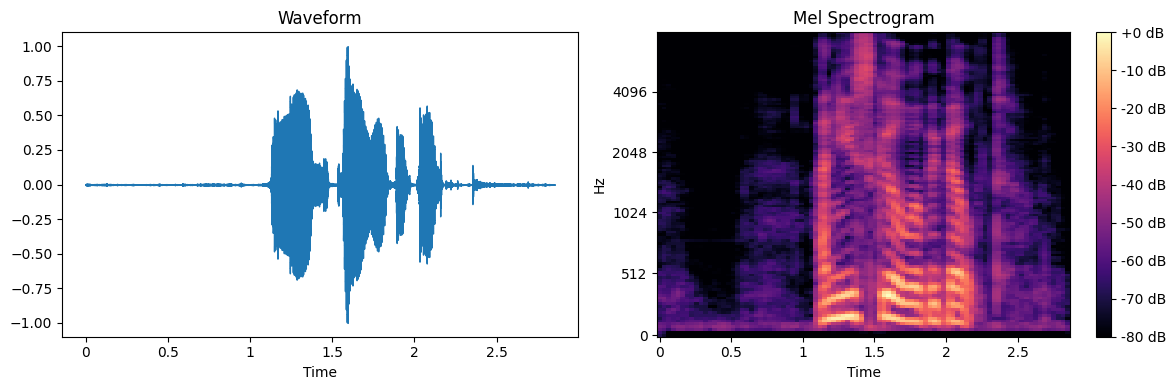

In [11]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

audio_path = '/content/drive/MyDrive/ASV_Dataset/Bonafide/LA_T_1000406.flac'
y, sr = librosa.load(audio_path, sr=None)

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000) ''' y=y → input audio signal, sr=sr → sampling rate, n_mels=128 → frequency resolution→ higher = more frequency
                                                                          detail, fmax=8000 → maximum frequency considered'''

S_dB = librosa.power_to_db(S, ref=np.max) # Converting to decibal scale using log

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')

plt.subplot(1, 2, 2)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')

plt.tight_layout()
plt.show()

**Examples of Mel Spectrograms from each class**

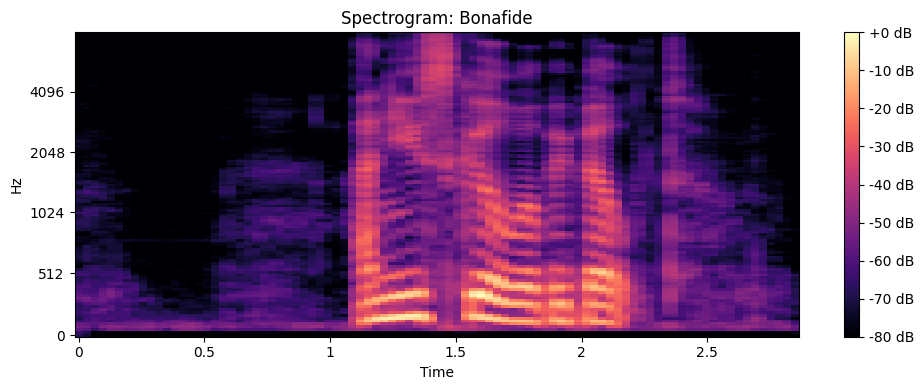

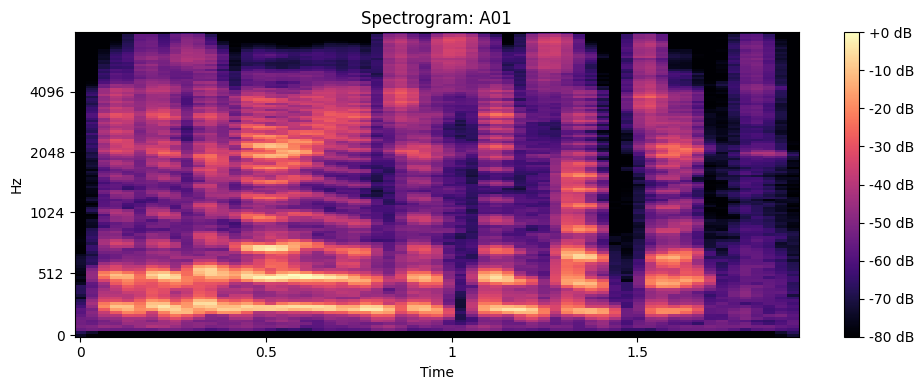

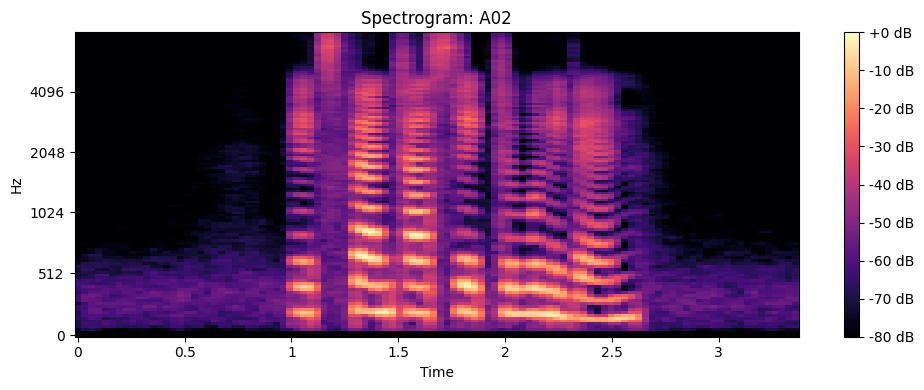

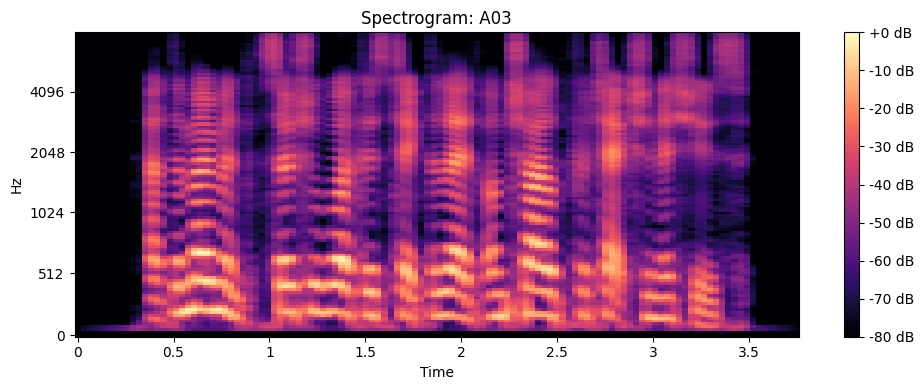

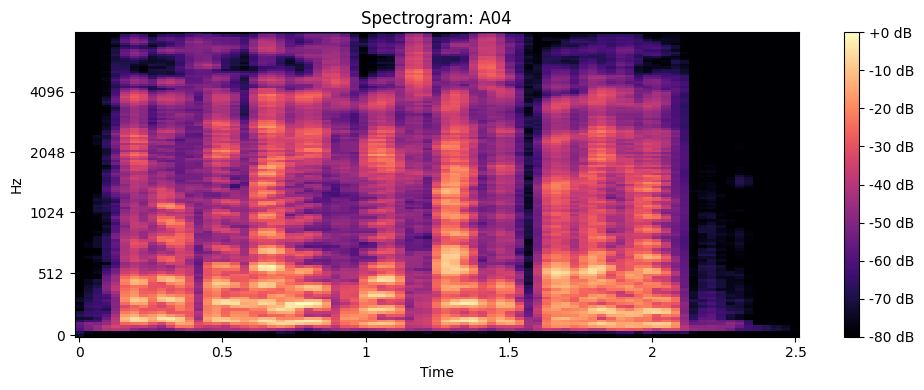

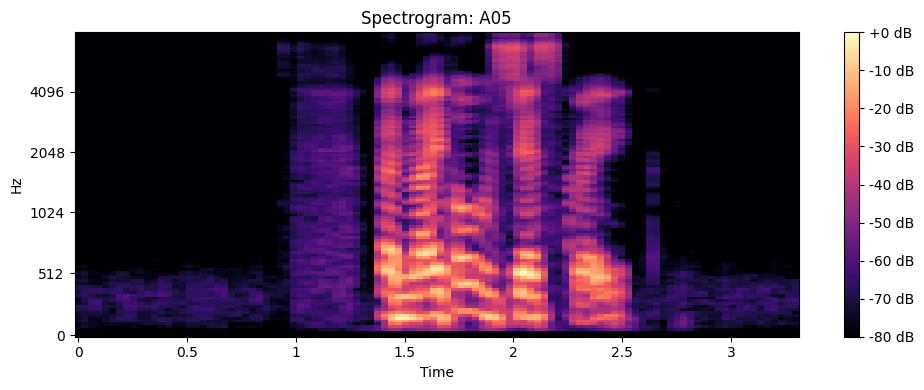

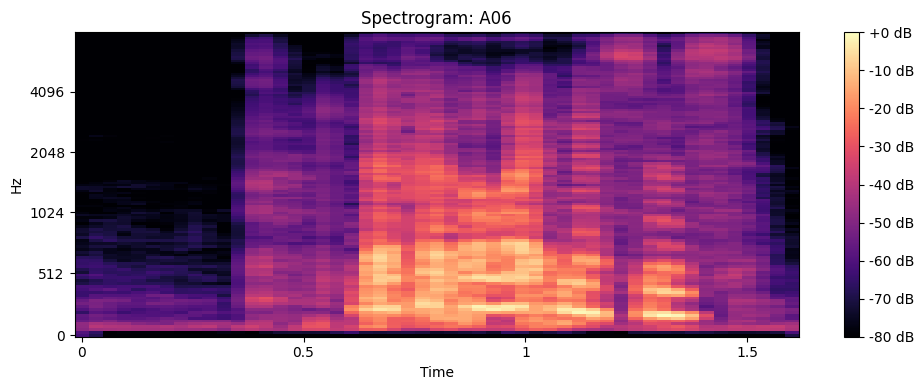

In [9]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_spectrogram(audio_path, title="Spectrogram"):
    y, sr = librosa.load(audio_path, sr=None)

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

audio_paths = {
    "Bonafide": "/content/drive/MyDrive/ASV_Dataset/Bonafide/LA_T_1000406.flac",
    "A01": "/content/drive/MyDrive/ASV_Dataset/Spoof/A01/LA_T_1000648.flac",
    "A02": "/content/drive/MyDrive/ASV_Dataset/Spoof/A02/LA_T_1003665.flac",
    "A03": "/content/drive/MyDrive/ASV_Dataset/Spoof/A03/LA_T_1001074.flac",
    "A04": "/content/drive/MyDrive/ASV_Dataset/Spoof/A04/LA_T_1000137.flac",
    "A05": "/content/drive/MyDrive/ASV_Dataset/Spoof/A05/LA_T_1001114.flac",
    "A06": "/content/drive/MyDrive/ASV_Dataset/Spoof/A06/LA_T_1011022.flac",
}

for label, path in audio_paths.items():
    plot_spectrogram(path, title=f"Spectrogram: {label}")

**Augmentation Demonstration**

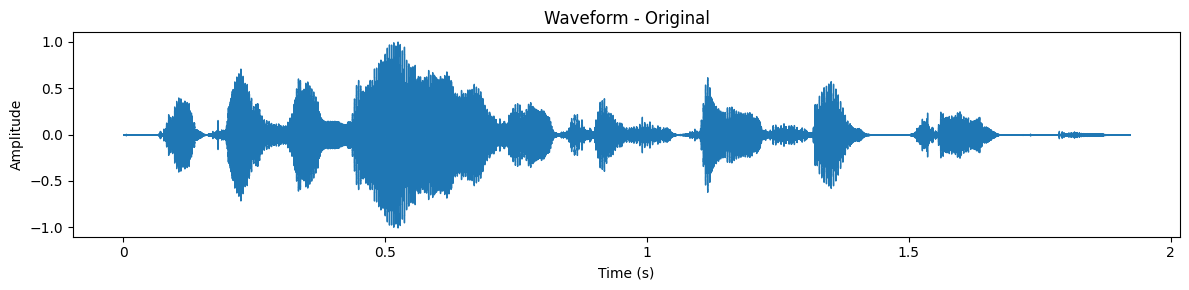

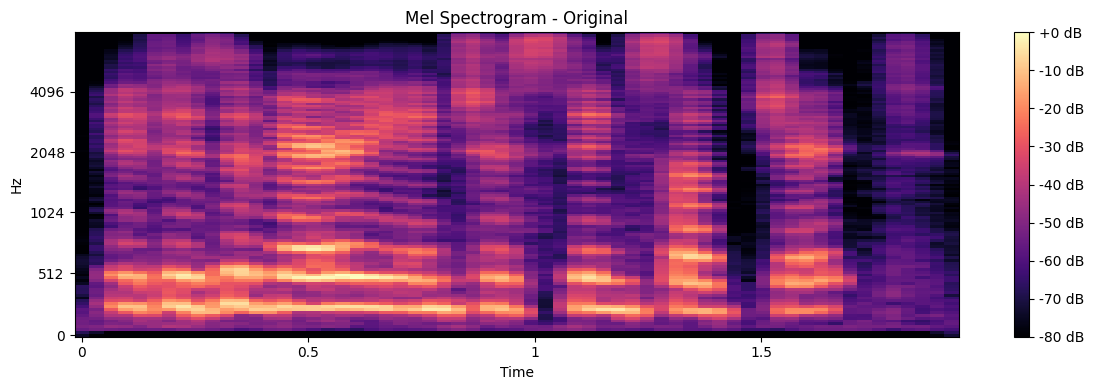

🔊 Playing: Original


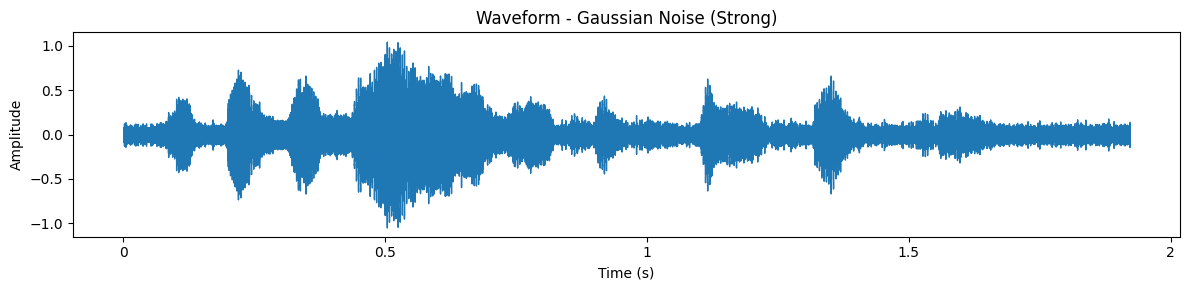

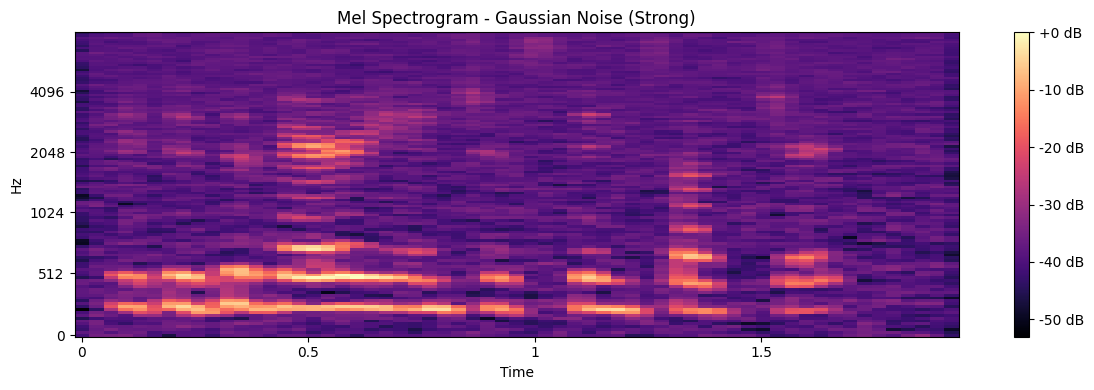

🔊 Playing: Gaussian Noise (Strong)


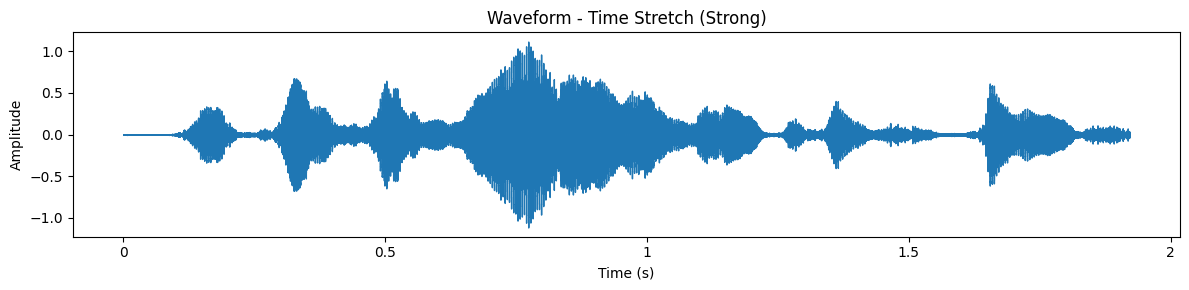

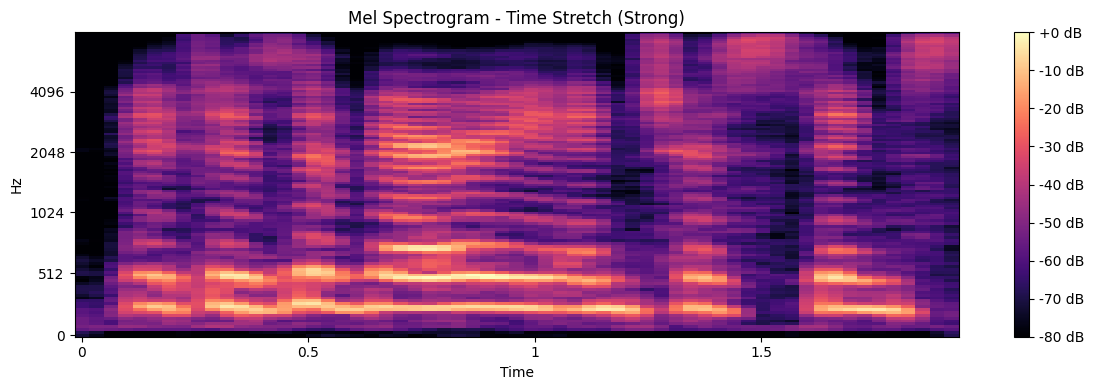

🔊 Playing: Time Stretch (Strong)


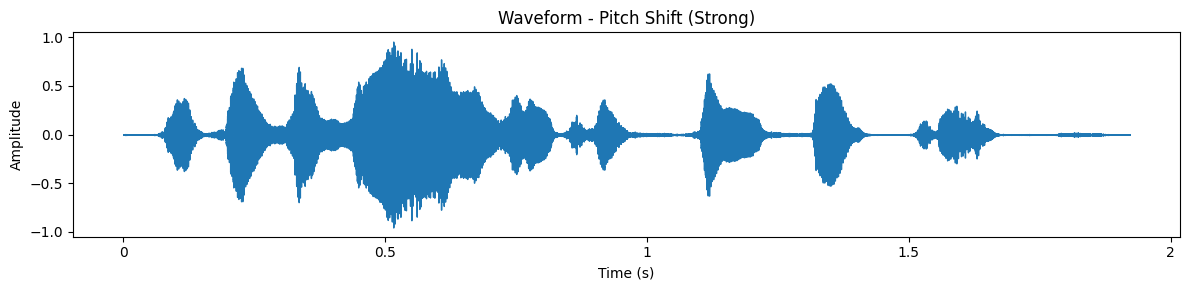

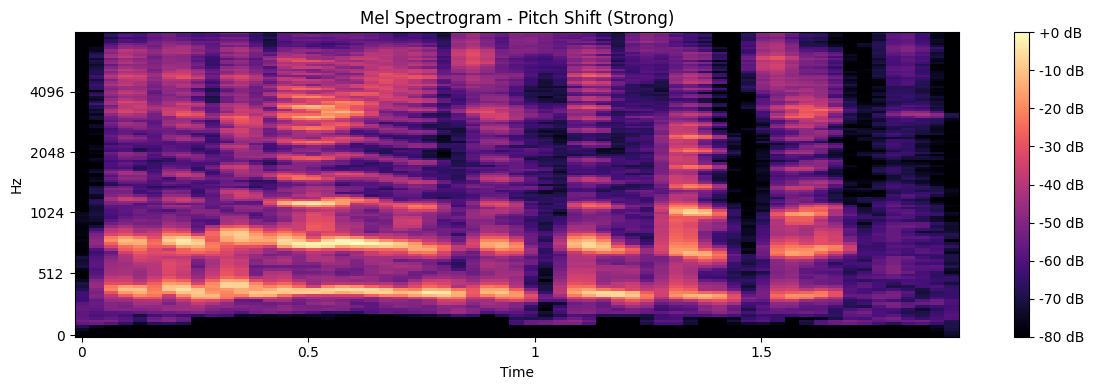

🔊 Playing: Pitch Shift (Strong)


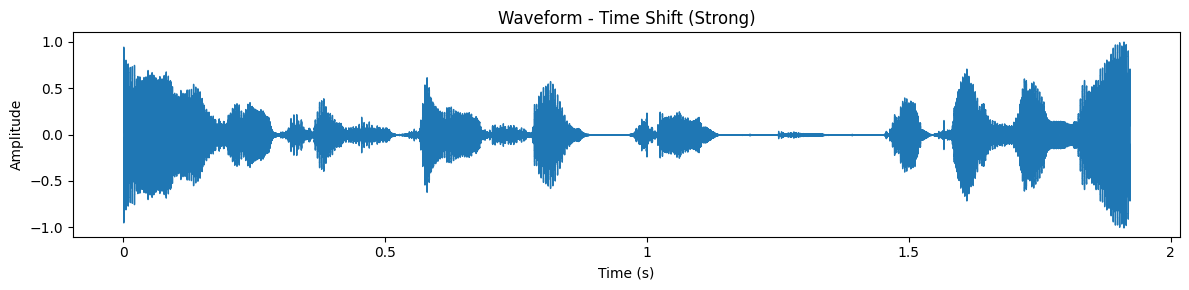

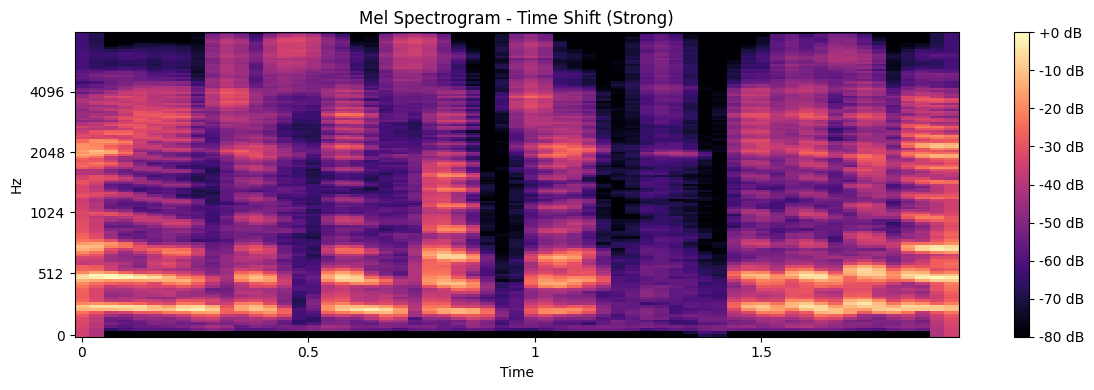

🔊 Playing: Time Shift (Strong)


In [15]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from audiomentations import (
    AddGaussianNoise,
    TimeStretch,
    PitchShift,
    Shift
)
from IPython.display import Audio, display

file_path = "/content/drive/MyDrive/ASV_Dataset/Spoof/A01/LA_T_1000648.flac" # Sample audio for demonstration
y, sr = librosa.load(file_path, sr=16000)

def plot_waveform(y, sr, title):
    plt.figure(figsize=(12, 3))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform - {title}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

def plot_mel(y, sr, title):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(
        mel_db,
        sr=sr,
        x_axis="time",
        y_axis="mel",
        cmap="magma"
    )
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Mel Spectrogram - {title}")
    plt.tight_layout()
    plt.show()

def show_audio(y, sr, title):
    print(f"🔊 Playing: {title}")
    display(Audio(y, rate=sr))

# Original audio
plot_waveform(y, sr, "Original")
plot_mel(y, sr, "Original")
show_audio(y, sr, "Original")

# 1. Strong Gaussian Noise
noise_aug = AddGaussianNoise(
    min_amplitude=0.02,
    max_amplitude=0.05,
    p=1.0
)

y_noise = noise_aug(samples=y, sample_rate=sr)

plot_waveform(y_noise, sr, "Gaussian Noise (Strong)")
plot_mel(y_noise, sr, "Gaussian Noise (Strong)")
show_audio(y_noise, sr, "Gaussian Noise (Strong)")

# 2. Strong Time Stretch
stretch_aug = TimeStretch(
    min_rate=0.6,
    max_rate=1.6,
    p=1.0
)

y_stretch = stretch_aug(samples=y, sample_rate=sr)

plot_waveform(y_stretch, sr, "Time Stretch (Strong)")
plot_mel(y_stretch, sr, "Time Stretch (Strong)")
show_audio(y_stretch, sr, "Time Stretch (Strong)")

# 3. Strong Pitch Shift
pitch_aug = PitchShift(
    min_semitones=-8,
    max_semitones=8,
    p=1.0
)

y_pitch = pitch_aug(samples=y, sample_rate=sr)

plot_waveform(y_pitch, sr, "Pitch Shift (Strong)")
plot_mel(y_pitch, sr, "Pitch Shift (Strong)")
show_audio(y_pitch, sr, "Pitch Shift (Strong)")

# 4. Strong Time Shift
shift_aug = Shift(
    min_shift=-0.8,
    max_shift=0.8,
    p=1.0
)

y_shift = shift_aug(samples=y, sample_rate=sr)

plot_waveform(y_shift, sr, "Time Shift (Strong)")
plot_mel(y_shift, sr, "Time Shift (Strong)")
show_audio(y_shift, sr, "Time Shift (Strong)")

**Padding/Truncating the audio to exactly 256 time frames**

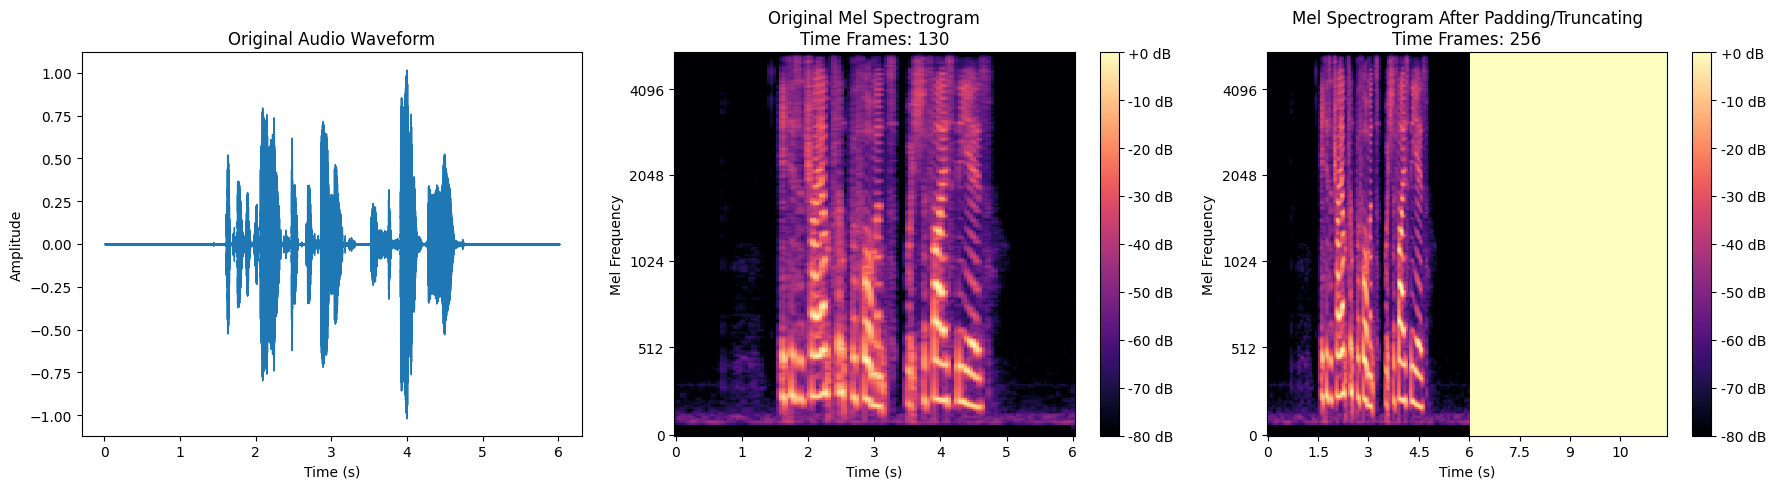

In [17]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

file_path = "/content/drive/MyDrive/ASV_Dataset/Bonafide/LA_T_1011221.flac"
y, sr = librosa.load(file_path, sr=11000)

mel_spectrogram_original = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256)
mel_spectrogram_db_original = librosa.power_to_db(mel_spectrogram_original, ref=np.max)

time_frames_original = mel_spectrogram_db_original.shape[1]

max_time_frames = 256
if mel_spectrogram_db_original.shape[1] > max_time_frames:
    mel_spectrogram_db_truncated = mel_spectrogram_db_original[:, :max_time_frames] # If time frame is more than 256, truncate the extra audio
    time_frames_truncated = max_time_frames
else:
    pad_width = max_time_frames - mel_spectrogram_db_original.shape[1]
    mel_spectrogram_db_truncated = np.pad(mel_spectrogram_db_original, ((0, 0), (0, pad_width)), mode='constant') # If time frame is less than 256, pad silent audio till 256
    time_frames_truncated = max_time_frames
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# This is done to ensure consistency in all audios before the CNN processes them

axes[0].set_title("Original Audio Waveform")
librosa.display.waveshow(y, sr=sr, ax=axes[0])
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")

axes[1].set_title(f"Original Mel Spectrogram\nTime Frames: {time_frames_original}")
img = librosa.display.specshow(mel_spectrogram_db_original, x_axis='time', y_axis='mel', sr=sr, ax=axes[1])
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Mel Frequency")
fig.colorbar(img, ax=axes[1], format='%+2.0f dB')

axes[2].set_title(f"Mel Spectrogram After Padding/Truncating\nTime Frames: {time_frames_truncated}")
img = librosa.display.specshow(mel_spectrogram_db_truncated, x_axis='time', y_axis='mel', sr=sr, ax=axes[2])
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Mel Frequency")
fig.colorbar(img, ax=axes[2], format='%+2.0f dB')

plt.tight_layout()
plt.show()